In [1]:
'''
The autonomous driving example on ppt from Bemporad
'''

'\nThe autonomous driving example on ppt from Bemporad\n'

In [2]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import controller

In [3]:
ctrl = controller.controller()

In [4]:
CL = 4.5
dt = 0.05
ctrl.dt = dt
''' 
x:[x,y,theta]
u:[v,delta]
'''
def f(x,u):
    return np.array([
        [(u[0]*np.cos(x[2]+u[1]))[0]],
        [(np.sin(x[2]+u[1])*u[0])[0]],
        [((np.sin(u[1])/CL)*u[0])[0]]
    ])

def matrix_iterator(x0,u0):
    A = np.array([
        [0,    0,  (-np.sin(x0[2]+u0[1])*u0[0])[0]],
        [0,    0,  (np.cos(x0[2]+u0[1])*u0[0])[0]],
        [0,    0,  0]
    ]
    )

    B = np.array(
        [
        [(np.cos(x0[2]+u0[1]))[0],(-np.sin(x0[2]+u0[1])*u0[0])[0]],
        [(np.sin(x0[2]+u0[1]))[0],(np.cos(x0[2]+u0[1])*u0[0])[0]],
        [(np.sin(u0[1])/CL)[0], (np.cos(u0[1])*u0[0]/CL)[0]]
        ]
    )

    '''f0 = np.array([
        [(np.cos(x0[2])*x0[3])[0]],
        [(np.sin(x0[2])*x0[3])[0]],
        [((np.tan(u0[1])/CL)*x0[3])[0]],
        [(0.5*u0[0])[0]]
    ])'''
    f0 = f(x0,u0)

    return A,B,f0

x0 = np.array(
    [
        [0],
        [10.],
        [0]
    ]
)

xd = np.array(
    [
        [0],
        [0.],
        [0]
    ]
)

u0 = np.array(
    [
        [25],
        [0]
    ]
)


In [5]:
ctrl.pred_horizon = 30
ctrl.control_horizon = 4 

'''
Because in this example cost contains increament, we create R_tilde mannually.
Finally J = \sum (x terms) + u^T R_tilde u + c^T u + d
'''
R_sub = np.array([
    [1,0,-1,0],[0,1,0,-1],[-1,0.,1,0],[0,-1,0,1]
])
R_tilde = np.zeros([2*ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon-1):
    R_tilde[2*i:2*i+4,2*i:2*i+4] += R_sub
R_tilde[0,0] += 1. 
R_tilde[1,1] += 1.

R_tilde *= 1./(ctrl.dt)**2

def c_param(x0,u0):
    c = np.zeros([2*ctrl.pred_horizon,1])
    #c[0]= -2*u0[0]
    #c[1] = -2*u0[1]
    c[0] = -u0[0]
    c[1] = -u0[1]
    return c.reshape(-1)/(ctrl.dt**2)

Q = np.array(
    [
        [0.,0,0],
        [0,1.,0],
        [0,0,1.]
    ]
)
F = Q 

ctrl.Q = Q 
ctrl.F = F 

In [6]:
'''
Construct the constraints 
'''
A1 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A1[i,2*i] = 1.
    #A1[i,2*i+1] = 1.
b1 = np.zeros([ctrl.pred_horizon,1]) - 20. 

A2 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A2[i,2*i] = -1.
    #A2[i,2*i+1] = -1.
b2 = np.zeros([ctrl.pred_horizon,1]) -70.

A3 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A3[i,2*i+1] = 1.
b3 = np.zeros([ctrl.pred_horizon,1]) - np.pi/4 

A4 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon):
    A4[i,2*i+1] = -1.
b4 = np.zeros([ctrl.pred_horizon,1]) - np.pi/4

A5 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
A5[0,1] = 1. 
b5 = [-np.pi/36*ctrl.dt + u0[1]]

A6 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
A6[0,1] = -1. 
b6 = [-np.pi/36*ctrl.dt - u0[1]]

A7 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon-2):
    A7[i,2*i+3] = -1/ctrl.dt  
    A7[i,2*i+5] = 1/ctrl.dt 

b7 = np.zeros([ctrl.pred_horizon-1,1]) - np.pi/36

A8 = np.zeros([ctrl.pred_horizon,2*ctrl.pred_horizon])
for i in range(ctrl.pred_horizon-2):
    A8[i,2*i+3] = 1/ctrl.dt  
    A8[i,2*i+5] = -1/ctrl.dt

b8 = np.zeros([ctrl.pred_horizon-1,1]) - np.pi/36

In [7]:
xlist = [x0]
ulist = [u0]
ctrl.setup_model(f)
for i in range(300):
    A,B,f0 = matrix_iterator(x0,u0)
    ctrl.update_dynamics(A,x0,B,u0,f0)

    #x1 = ctrl.apply_control(x0,u0)    
    x0 = ctrl.apply_control(x0,u0)   
    ctrl.discretize_by_R(dt,R_tilde)
    ctrl.setup_qp_linear(x0,u0,xd)  #x1 is not controllable, since u0 must be applied. Here u0 is dummy.

    c = c_param(x0,u0)
    u = ctrl.solve_qp(extra = c)
    u0 = u[0:2].reshape(-1,1)
    #x0 = ctrl.apply_control(x0,u0)
    xlist.append(x0)
    ulist.append(u0)
    #print('stepped')


In [8]:
import matplotlib.pyplot as plt

In [9]:
xm = np.array(xlist).squeeze(-1)
print(xm.shape)

(301, 3)


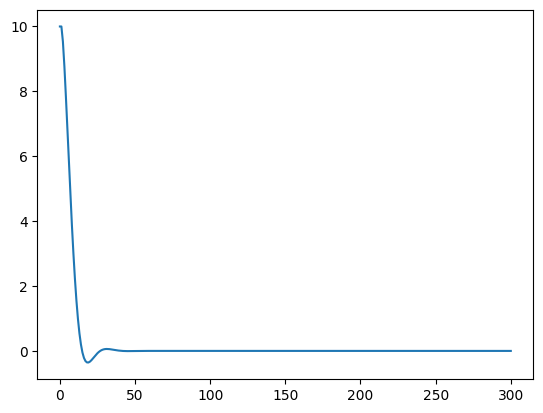

In [10]:
plt.plot(xm[:,1])

In [11]:
u_tilde = np.array(ulist).reshape(-1,2)

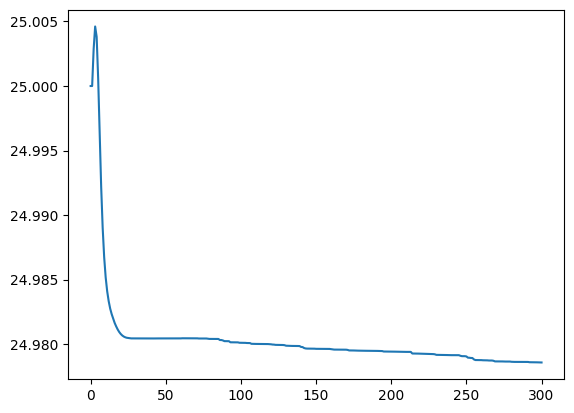

In [13]:
plt.plot(u_tilde[:,0])